In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from matplotlib.font_manager import FontProperties
import random
import pickle
import warnings
warnings.filterwarnings("ignore")
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

test_freq=500

activations = {
    'relu':    nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'elu':     nn.ELU(),
    'tanh':    nn.Tanh(),
    'gelu':    nn.GELU(),
    'leaky_relu': nn.LeakyReLU()
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
from misc import preprocessing
_ = preprocessing()

cuda:0


### Data

In [3]:
df = pd.read_csv('./2D-undrain-data.csv', header=0)

group = df['group'].values
variables = {
    'q_t': df['q_t'].values,
    'q_tdt': df['q_tdt'].values,
    'p_t': df['p_t'].values,
    'p_tdt': df['p_tdt'].values,
    'pl_strain_t': df['pl_e1_t'].values,
    'pl_strain_tdt': df['pl_e1_tdt'].values,
    'el_strain_t': df['el_e1_t'].values,
    'el_strain_tdt': df['el_e1_tdt'].values,
    'strain_t': df['e1_t'].values,
    'strain_tdt': df['e1_tdt'].values,
    'q_dynamic_tdt': df['q_dynamic_tdt'].values,
    'p_dynamic_tdt': df['p_dynamic_tdt'].values,
    'strain_dynamic_tdt': df['e1_dynamic_tdt'].values
}

variables.update({
    'dq': variables['q_tdt'] - variables['q_t'],
    'dp': variables['p_tdt'] - variables['p_t'],
    'dstrain': variables['strain_tdt'] - variables['strain_t'],
    'dstrain_pl': variables['pl_strain_tdt'] - variables['pl_strain_t'],
    'dstrain_el': variables['el_strain_tdt'] - variables['el_strain_t']
})

In [4]:
def split_by_group(data_array, group_array):
    tv_mask = (group_array == 1)
    tv_data = data_array[tv_mask]
    
    test_data = {}
    for g in range(2, 8):
        test_mask = (group_array == g)
        test_data[f'test{g-1}'] = data_array[test_mask]
    
    return tv_data, test_data

for var_name, data in variables.items():
    tv_data, test_data = split_by_group(data, group)
    
    globals()[f"{var_name}_tv"] = tv_data.reshape(1, -1, 1, 1)
    for test_id, test_values in test_data.items():
        globals()[f"{var_name}_{test_id}"] = test_values.reshape(1, -1, 1, 1)

In [5]:
prm_a = _.GetParams(strain_tdt_tv)
prm_da = _.GetParams(dstrain_tv)
prm_al = _.GetParams(strain_t_tv)

prm_p = _.GetParams(p_tdt_tv)
prm_dp = _.GetParams(dp_tv)
prm_pl = _.GetParams(p_t_tv)

prm_q = _.GetParams(q_tdt_tv)
prm_dq = _.GetParams(dq_tv)
prm_ql = _.GetParams(q_t_tv)

prm_z = _.GetParams(pl_strain_tdt_tv)
prm_zl = _.GetParams(pl_strain_t_tv)
prm_dz = _.GetParams(dstrain_pl_tv)

prm_e = _.GetParams(el_strain_tdt_tv)
prm_el = _.GetParams(el_strain_t_tv)
prm_de = _.GetParams(dstrain_el_tv)

prm_df = _.GetParams(dstrain_el_tv*q_tdt_tv + dstrain_pl_tv*p_tdt_tv)
prm_d = _.GetParams(dstrain_pl_tv*q_tdt_tv)

prm_dyq = _.GetParams(q_dynamic_tdt_tv)
prm_dyp = _.GetParams(p_dynamic_tdt_tv)
prm_dya = _.GetParams(strain_dynamic_tdt_tv)

base_var_mapping = {
    'strain_tdt': 'prm_a',
    'dstrain': 'prm_da',
    'strain_t': 'prm_al',
    'p_tdt': 'prm_p',
    'dp': 'prm_dp',
    'p_t': 'prm_pl',
    'q_tdt': 'prm_q',
    'dq': 'prm_dq',
    'q_t': 'prm_ql',
    'pl_strain_tdt': 'prm_z',
    'pl_strain_t': 'prm_zl',
    'dstrain_pl': 'prm_dz',
    'el_strain_tdt': 'prm_e',
    'el_strain_t': 'prm_el',
    'dstrain_el': 'prm_de',
    'q_dynamic_tdt': 'prm_dyq',
    'p_dynamic_tdt': 'prm_dyp',
    'strain_dynamic_tdt': 'prm_dya'
}

combined_var_mapping = {
    ('dstrain_el*q_tdt + dstrain_pl*p_tdt', ('dstrain_el', 'q_tdt', 'dstrain_pl', 'p_tdt')): 'prm_df',
    ('dstrain_pl*q_tdt', ('dstrain_pl', 'q_tdt')): 'prm_d'
}

for test_num in range(1, 7):
    for var_suffix, param_prefix in base_var_mapping.items():
        test_data = globals().get(f"{var_suffix}_test{test_num}")
        
        if test_data is not None:
            param_name = f"{param_prefix}_test{test_num}"
            globals()[param_name] = _.GetParams(test_data)
    
    for (expression, components), param_prefix in combined_var_mapping.items():
        component_data = []
        for comp in components:
            data = globals().get(f"{comp}_test{test_num}")
            if data is None:
                break
            component_data.append(data)
        
        if len(component_data) == len(components):
            try:
                combined = eval(expression.replace('_testX', ''), 
                              {comp: data for comp, data in zip(components, component_data)})
                globals()[f"{param_prefix}_test{test_num}"] = _.GetParams(combined)
            except Exception as e:
                print(f"test{test_num}参数{param_prefix}error: {str(e)}")

### Re-TINN 

In [6]:
class TANN(nn.Module):
    def __init__(self, params_p, params_e, params_q, params_s, params_x, params_pt, dtype=torch.float32):
        super(TANN, self).__init__()
        self.dtype = dtype

        self.NNp = self.constructor(*params_p)
        self.NNe = self.constructor(*params_e)
        self.NNq = self.constructor(*params_q)
        self.NNs = self.constructor(*params_s)
        self.NNx = self.constructor(*params_x)
        self.NNpt = self.constructor(*params_pt)
        
        self.saved_nn_s_input = None
        self.saved_stress_s = None          

    def constructor(self, i_dim, o_dim, h_dim, act):
        layers = nn.Sequential()
        dim = i_dim
        for hdim in h_dim:
            layers.append(nn.Linear(dim, hdim, dtype=self.dtype))
            layers.append(activations[act])
            dim = hdim
        layers.append(nn.Linear(dim, o_dim, dtype=self.dtype))
        return layers

    def Normalize(self, inputs, prm):
        return (inputs - prm[1]) / prm[0]

    def DeNormalize(self, outputs, prm):
        return outputs * prm[0] + prm[1]

    def forward(self, inp):
        inp = torch.autograd.Variable(inp, requires_grad=True)

        n_strain_tdt, n_dstrain, n_q_t, n_p_t, n_pl_strain_t, n_el_strain_t, \
        n_q_dyn, n_p_dyn, n_strain_dyn = torch.split(inp, [1,1,1,1,1,1,1,1,1], dim=1)

        nn_p_input = torch.cat((n_strain_tdt, n_dstrain, n_q_t, n_p_t, n_pl_strain_t), 1)
        n_dstrain_pl = self.NNp(nn_p_input)
        dstrain_pl = self.DeNormalize(n_dstrain_pl, prm_dz)

        nn_e_input = torch.cat((n_strain_tdt, n_dstrain, n_q_t, n_p_t, n_el_strain_t), 1)
        n_dstrain_el = self.NNe(nn_e_input)
        dstrain_el = self.DeNormalize(n_dstrain_el, prm_de)

        pl_strain_tdt = dstrain_pl + self.DeNormalize(n_pl_strain_t, prm_zl)
        el_strain_tdt = dstrain_el + self.DeNormalize(n_el_strain_t, prm_el)

        nn_q_input = torch.cat((
            n_dstrain_el,
            self.Normalize(el_strain_tdt, prm_e),
            n_q_t
        ), 1)
        n_q_tdt = self.NNq(nn_q_input)
        q_tdt = self.DeNormalize(n_q_tdt, prm_q)

        nn_s_input = torch.cat([
            n_q_dyn,
            n_p_dyn,
            n_strain_dyn,
            n_dstrain_pl,
            self.Normalize(pl_strain_tdt, prm_z),
            n_q_t,
            n_p_t
        ], dim=1)
        n_stress_s = self.NNs(nn_s_input)
        stress_s = self.DeNormalize(n_stress_s, prm_p)
        self.saved_nn_s_input = nn_s_input.detach()
        self.saved_stress_s = stress_s.detach()

        nn_x_input = torch.cat((
            n_dstrain_pl,
            self.Normalize(pl_strain_tdt, prm_z),
            n_q_t,
            n_p_t
        ), 1)
        n_stress_x = self.NNx(nn_x_input)
        stress_x = self.DeNormalize(n_stress_x, prm_q)

        nn_pt_input = torch.cat((
            n_q_tdt,
            n_stress_s,
            n_stress_x
        ), 1)
        n_p_tdt = self.NNpt(nn_pt_input)
        p_tdt = self.DeNormalize(n_p_tdt, prm_p)        

        pl_denergy = stress_s * dstrain_pl
        el_denergy = q_tdt * dstrain_el
        pred_denergy = pl_denergy + el_denergy
        
        pred_dissipation = (stress_x * dstrain_pl)
        
        return torch.cat((
            self.Normalize(pl_strain_tdt, prm_z),
            self.Normalize(el_strain_tdt, prm_e),
            self.Normalize(q_tdt, prm_q),
            self.Normalize(p_tdt, prm_p),
            self.Normalize(pred_denergy, prm_df),
            self.Normalize(pred_dissipation, prm_d)
        ), 1)

params_p = [5, 1, [32,32,32], 'relu']
params_e = [5, 1, [32,32,32], 'relu']
params_q = [3, 1, [32,32,32], 'gelu']
params_s = [7, 1, [96,96], 'gelu']
params_x = [4, 1, [96,96], 'gelu']
params_pt = [3, 1, [16,16], 'gelu']

TANNnet = TANN(
    params_p=params_p,
    params_e=params_e,
    params_q=params_q,
    params_s=params_s,
    params_x=params_x,
    params_pt=params_pt,
    dtype=torch.float64
).to(device)
TANNnet.to(torch.double)

TANN(
  (NNp): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (NNe): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (NNq): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): GELU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): GELU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
  (NNs): Sequential(
    (0): Linear(in_features=7, out_featu

In [7]:
strain_t_tv = TANNnet.Normalize(torch.tensor(strain_t_tv), prm_al)
strain_tdt_tv = TANNnet.Normalize(torch.tensor(strain_tdt_tv), prm_a)
pl_strain_t_tv = TANNnet.Normalize(torch.tensor(pl_strain_t_tv), prm_zl)
pl_strain_tdt_tv = TANNnet.Normalize(torch.tensor(pl_strain_tdt_tv), prm_z)
el_strain_t_tv = TANNnet.Normalize(torch.tensor(el_strain_t_tv), prm_el)
el_strain_tdt_tv = TANNnet.Normalize(torch.tensor(el_strain_tdt_tv), prm_e)
p_t_tv = TANNnet.Normalize(torch.tensor(p_t_tv), prm_pl)
p_tdt_tv = TANNnet.Normalize(torch.tensor(p_tdt_tv), prm_p)
q_t_tv = TANNnet.Normalize(torch.tensor(q_t_tv), prm_ql)
q_tdt_tv = TANNnet.Normalize(torch.tensor(q_tdt_tv), prm_q)
p_dyn_tv = TANNnet.Normalize(torch.tensor(p_dynamic_tdt_tv), prm_dyp)
q_dyn_tv = TANNnet.Normalize(torch.tensor(q_dynamic_tdt_tv), prm_dyq)
strain_dyn_tv = TANNnet.Normalize(torch.tensor(strain_dynamic_tdt_tv), prm_dya)

dstrain_tv = TANNnet.Normalize(torch.tensor(dstrain_tv), prm_da)
dstrain_pl_tv = TANNnet.Normalize(torch.tensor(dstrain_pl_tv), prm_dz)
dstrain_el_tv = TANNnet.Normalize(torch.tensor(dstrain_el_tv), prm_de)
denergy_tv = TANNnet.Normalize(torch.tensor(dstrain_el_tv*q_tdt_tv + dstrain_pl_tv*p_tdt_tv), prm_df)
dissipation_rate_tdt_tv = TANNnet.Normalize(torch.tensor(dstrain_pl_tv*q_tdt_tv), prm_d)

input_tv = torch.cat((
    strain_tdt_tv, 
    dstrain_tv,
    q_t_tv,
    p_t_tv,
    pl_strain_t_tv,
    el_strain_t_tv,
    q_dyn_tv,
    p_dyn_tv,
    strain_dyn_tv), -1).to(device)

output_tv = torch.cat((pl_strain_tdt_tv,
                       el_strain_tdt_tv,
                       q_tdt_tv,
                       p_tdt_tv,
                       denergy_tv,
                       dissipation_rate_tdt_tv), -1).to(device)

In [8]:
test_groups = range(1, 7)

for test_num in test_groups:
    strain_t_test = TANNnet.Normalize(torch.tensor(globals()[f"strain_t_test{test_num}"]), globals()[f"prm_al_test{test_num}"])
    strain_tdt_test = TANNnet.Normalize(torch.tensor(globals()[f"strain_tdt_test{test_num}"]), globals()[f"prm_a_test{test_num}"])
    pl_strain_t_test = TANNnet.Normalize(torch.tensor(globals()[f"pl_strain_t_test{test_num}"]), globals()[f"prm_zl_test{test_num}"])
    pl_strain_tdt_test = TANNnet.Normalize(torch.tensor(globals()[f"pl_strain_tdt_test{test_num}"]), globals()[f"prm_z_test{test_num}"])
    el_strain_t_test = TANNnet.Normalize(torch.tensor(globals()[f"el_strain_t_test{test_num}"]), globals()[f"prm_el_test{test_num}"])
    el_strain_tdt_test = TANNnet.Normalize(torch.tensor(globals()[f"el_strain_tdt_test{test_num}"]), globals()[f"prm_e_test{test_num}"])
    p_t_test = TANNnet.Normalize(torch.tensor(globals()[f"p_t_test{test_num}"]), globals()[f"prm_pl_test{test_num}"])
    p_tdt_test = TANNnet.Normalize(torch.tensor(globals()[f"p_tdt_test{test_num}"]), globals()[f"prm_p_test{test_num}"])
    q_t_test = TANNnet.Normalize(torch.tensor(globals()[f"q_t_test{test_num}"]), globals()[f"prm_ql_test{test_num}"])
    q_tdt_test = TANNnet.Normalize(torch.tensor(globals()[f"q_tdt_test{test_num}"]), globals()[f"prm_q_test{test_num}"])
    p_dyn_test = TANNnet.Normalize(torch.tensor(globals()[f"p_dynamic_tdt_test{test_num}"]), globals()[f"prm_dyp_test{test_num}"])
    q_dyn_test = TANNnet.Normalize(torch.tensor(globals()[f"q_dynamic_tdt_test{test_num}"]), globals()[f"prm_dyq_test{test_num}"])
    strain_dyn_test = TANNnet.Normalize(torch.tensor(globals()[f"strain_dynamic_tdt_test{test_num}"]), globals()[f"prm_dya_test{test_num}"])

    dstrain_test = TANNnet.Normalize(torch.tensor(globals()[f"dstrain_test{test_num}"]), globals()[f"prm_da_test{test_num}"])
    dstrain_pl_test = TANNnet.Normalize(torch.tensor(globals()[f"dstrain_pl_test{test_num}"]), globals()[f"prm_dz_test{test_num}"])
    dstrain_el_test = TANNnet.Normalize(torch.tensor(globals()[f"dstrain_el_test{test_num}"]), globals()[f"prm_de_test{test_num}"])
    denergy_test = TANNnet.Normalize(
        torch.tensor(globals()[f"dstrain_el_test{test_num}"] * globals()[f"q_tdt_test{test_num}"] + 
                     globals()[f"dstrain_pl_test{test_num}"] * globals()[f"p_tdt_test{test_num}"]),
        globals()[f"prm_df_test{test_num}"]
    )
    
    dissipation_rate_tdt_test = TANNnet.Normalize(
        torch.tensor(globals()[f"dstrain_pl_test{test_num}"] * globals()[f"q_tdt_test{test_num}"]),
        globals()[f"prm_d_test{test_num}"]
    )

    globals()[f"input_test{test_num}"] = torch.cat((
        strain_tdt_test, 
        dstrain_test,
        q_t_test,
        p_t_test,
        pl_strain_t_test,
        el_strain_t_test,
        q_dyn_test,
        p_dyn_test,
        strain_dyn_test), -1).to(device)

    globals()[f"output_test{test_num}"] = torch.cat((
        pl_strain_tdt_test,
        el_strain_tdt_test,
        q_tdt_test,
        p_tdt_test,
        denergy_test,
        dissipation_rate_tdt_test), -1).to(device)

### Training

Iter 100: Total=0.7229 | Data=0.6452 | Phy=0.1554
Iter 200: Total=0.4925 | Data=0.4811 | Phy=0.0227
Iter 300: Total=0.2822 | Data=0.2766 | Phy=0.0113
Iter 400: Total=0.1496 | Data=0.1460 | Phy=0.0071
Iter 500: Total=0.0781 | Data=0.0750 | Phy=0.0062
Iter 600: Total=0.0523 | Data=0.0499 | Phy=0.0048
Iter 700: Total=0.0374 | Data=0.0348 | Phy=0.0052
Iter 800: Total=0.0269 | Data=0.0234 | Phy=0.0069
Iter 900: Total=0.0208 | Data=0.0165 | Phy=0.0086
Iter 1000: Total=0.0173 | Data=0.0128 | Phy=0.0089


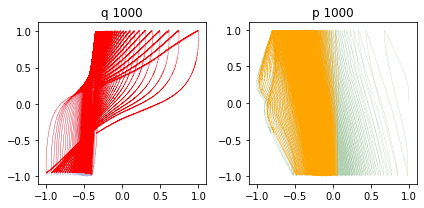

Iter 1100: Total=0.0148 | Data=0.0108 | Phy=0.0081
Iter 1200: Total=0.0128 | Data=0.0093 | Phy=0.0070
Iter 1300: Total=0.0112 | Data=0.0082 | Phy=0.0058
Iter 1400: Total=0.0098 | Data=0.0074 | Phy=0.0048
Iter 1500: Total=0.0086 | Data=0.0067 | Phy=0.0038
Iter 1600: Total=0.0076 | Data=0.0061 | Phy=0.0031
Iter 1700: Total=0.0068 | Data=0.0055 | Phy=0.0025
Iter 1800: Total=0.0060 | Data=0.0050 | Phy=0.0020
Iter 1900: Total=0.0053 | Data=0.0045 | Phy=0.0017
Iter 2000: Total=0.0046 | Data=0.0040 | Phy=0.0014


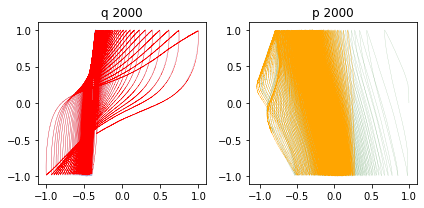

Iter 2100: Total=0.0040 | Data=0.0034 | Phy=0.0011
Iter 2200: Total=0.0034 | Data=0.0029 | Phy=0.0009
Iter 2300: Total=0.0029 | Data=0.0025 | Phy=0.0008
Iter 2400: Total=0.0023 | Data=0.0020 | Phy=0.0007
Iter 2500: Total=0.0019 | Data=0.0016 | Phy=0.0005
Iter 2600: Total=0.0015 | Data=0.0013 | Phy=0.0005
Iter 2700: Total=0.0012 | Data=0.0010 | Phy=0.0004
Iter 2800: Total=0.0009 | Data=0.0008 | Phy=0.0003
Iter 2900: Total=0.0007 | Data=0.0006 | Phy=0.0003
Iter 3000: Total=0.0006 | Data=0.0005 | Phy=0.0002


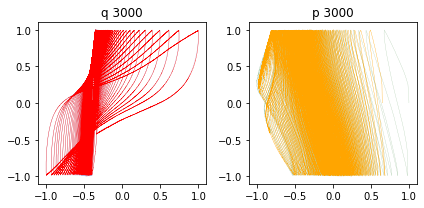

Iter 3100: Total=0.0005 | Data=0.0004 | Phy=0.0002
Iter 3200: Total=0.0005 | Data=0.0004 | Phy=0.0002
Iter 3300: Total=0.0004 | Data=0.0003 | Phy=0.0002
Iter 3400: Total=0.0004 | Data=0.0003 | Phy=0.0002
Iter 3500: Total=0.0003 | Data=0.0003 | Phy=0.0002
Iter 3600: Total=0.0003 | Data=0.0002 | Phy=0.0001
Iter 3700: Total=0.0003 | Data=0.0002 | Phy=0.0001
Iter 3800: Total=0.0003 | Data=0.0002 | Phy=0.0001
Iter 3900: Total=0.0002 | Data=0.0002 | Phy=0.0001
Iter 4000: Total=0.0002 | Data=0.0002 | Phy=0.0001


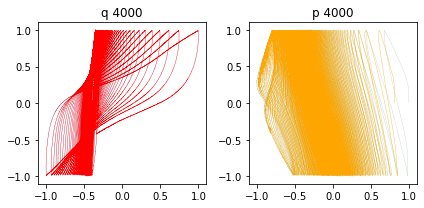

Iter 4100: Total=0.0002 | Data=0.0002 | Phy=0.0001
Iter 4200: Total=0.0002 | Data=0.0001 | Phy=0.0001
Iter 4300: Total=0.0002 | Data=0.0001 | Phy=0.0001
Iter 4400: Total=0.0002 | Data=0.0001 | Phy=0.0001
Iter 4500: Total=0.0002 | Data=0.0001 | Phy=0.0001
Iter 4600: Total=0.0001 | Data=0.0001 | Phy=0.0001
Iter 4700: Total=0.0001 | Data=0.0001 | Phy=0.0001
Iter 4800: Total=0.0001 | Data=0.0001 | Phy=0.0001
Iter 4900: Total=0.0001 | Data=0.0001 | Phy=0.0001
Iter 5000: Total=0.0001 | Data=0.0001 | Phy=0.0001


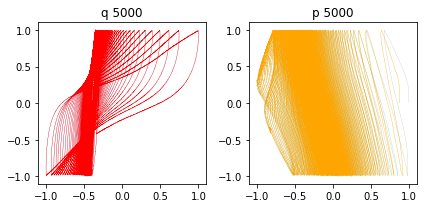

Iter 5100: Total=0.0001 | Data=0.0001 | Phy=0.0001
Iter 5200: Total=0.0001 | Data=0.0001 | Phy=0.0001
Iter 5300: Total=0.0001 | Data=0.0001 | Phy=0.0001
Iter 5400: Total=0.0001 | Data=0.0001 | Phy=0.0001
Iter 5500: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 5600: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 5700: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 5800: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 5900: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 6000: Total=0.0001 | Data=0.0000 | Phy=0.0001


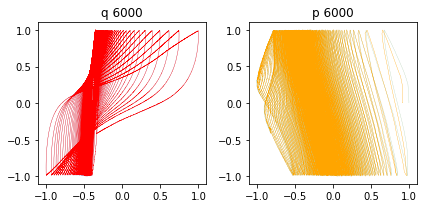

Iter 6100: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 6200: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 6300: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 6400: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 6500: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 6600: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 6700: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 6800: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 6900: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 7000: Total=0.0001 | Data=0.0000 | Phy=0.0001


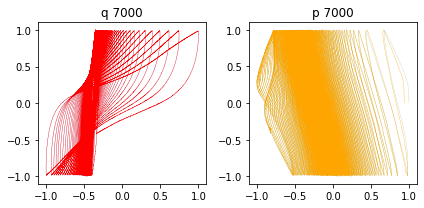

Iter 7100: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 7200: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 7300: Total=0.0001 | Data=0.0000 | Phy=0.0001
Iter 7400: Total=0.0001 | Data=0.0000 | Phy=0.0000
Iter 7500: Total=0.0001 | Data=0.0000 | Phy=0.0000
Iter 7600: Total=0.0001 | Data=0.0000 | Phy=0.0000
Iter 7700: Total=0.0001 | Data=0.0000 | Phy=0.0000
Iter 7800: Total=0.0001 | Data=0.0000 | Phy=0.0000
Iter 7900: Total=0.0001 | Data=0.0000 | Phy=0.0000
Iter 8000: Total=0.0000 | Data=0.0000 | Phy=0.0000


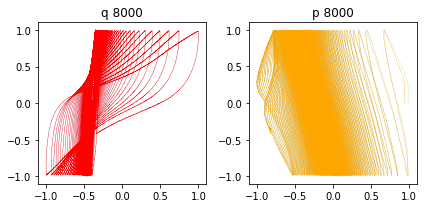

Iter 8100: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 8200: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 8300: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 8400: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 8500: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 8600: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 8700: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 8800: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 8900: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 9000: Total=0.0000 | Data=0.0000 | Phy=0.0000


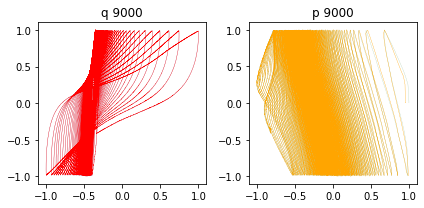

Iter 9100: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 9200: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 9300: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 9400: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 9500: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 9600: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 9700: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 9800: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 9900: Total=0.0000 | Data=0.0000 | Phy=0.0000
Iter 10000: Total=0.0000 | Data=0.0000 | Phy=0.0000


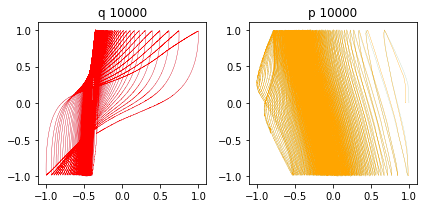

In [9]:
niters=10000
optimizer = optim.NAdam(
    TANNnet.parameters(), 
    lr=1e-4)
loss_components_hist = [[] for _ in range(2)]
total_loss_hist = []  
data_loss_hist = []   
phy_loss_hist = []    
phy_weight = 0.5
loss_fn = torch.nn.MSELoss()

test_p_loss_hist = []

for itr in range(1, niters + 1):
    epoch_data = 0.0
    epoch_phy = 0.0
    epoch_losses = [0.0] * 2
 
    i = 0
    pred = TANNnet(input_tv[i, :, 0])
    inputs = input_tv[i, :, 0]
    targets = output_tv[i, :, 0]

    losses = [
        loss_fn(pred[:, 2], output_tv[i, :, 0, 2]),
        loss_fn(pred[:, 3], output_tv[i, :, 0, 3]),
    ]
    data_loss = sum(losses)

    pred_denergy = TANNnet.DeNormalize(pred[:, 4], prm_df)
    pred_dissipation = TANNnet.DeNormalize(pred[:, 5], prm_d)
    q_real = TANNnet.DeNormalize(targets[:, 2], prm_q)
    p_real = TANNnet.DeNormalize(targets[:, 3], prm_p)
    dstrain_real = TANNnet.DeNormalize(inputs[:, 1], prm_da)
    dstrain_pl_real = TANNnet.DeNormalize(targets[:, 0]-inputs[:, 4], prm_dz)
    energy_balance = (pred_denergy + pred_dissipation - q_real * dstrain_real - p_real * dstrain_pl_real)
    non_neg_term = torch.relu(-pred_dissipation)
    phy_loss = torch.mean(energy_balance.pow(2)) + torch.mean(non_neg_term)

    total_loss = data_loss + phy_weight * phy_loss
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    for idx in range(2):
        epoch_losses[idx] += losses[idx].item()
    epoch_data += data_loss.item()
    epoch_phy += phy_loss.item()

    avg_losses = [loss / 1 for loss in epoch_losses]
    for idx in range(2):
        loss_components_hist[idx].append(avg_losses[idx])
    avg_total = (epoch_data + phy_weight * epoch_phy) / 1
    avg_data = epoch_data / 1
    avg_phy = epoch_phy / 1

    if itr % test_freq == 0:
        TANNnet.eval()
        total_test_p_loss = 0.0
        test_sample_count = 0
        
        with torch.no_grad():
            for test_num in range(1, 7):
                input_test = globals()[f"input_test{test_num}"]
                output_test = globals()[f"output_test{test_num}"]
                
                n_test = input_test.shape[0]
                for i in range(n_test):
                    pred_test = TANNnet(input_test[i, :, 0])
                    p_real = output_test[i, :, 0, 3]
                    p_pre = pred_test[:, 3]

                    p_loss = loss_fn(torch.tensor(p_real), torch.tensor(p_pre))
                    
                    total_test_p_loss += p_loss.item()
                    test_sample_count += 1
        
        avg_test_p_loss = total_test_p_loss / test_sample_count
        test_p_loss_hist.append(avg_test_p_loss)


    total_loss_hist.append(avg_total)
    data_loss_hist.append(avg_data)
    phy_loss_hist.append(avg_phy)

    if itr % 100 == 0:
        print(f"Iter {itr}: Total={avg_total:.4f} | Data={avg_data:.4f} | Phy={avg_phy:.4f}")

    if itr % (test_freq*2) == 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
        
        ax1.plot(strain_t_tv[i,:,0], output_tv[i,:,0,2].cpu().numpy(),
                color='darkblue', alpha=0.3, linestyle='-', linewidth=0.3, label='True')
        ax1.plot(strain_t_tv[i,:,0], pred.detach()[:,2].cpu().numpy(),
                color='red', label='Pred', linewidth=0.3)
        ax1.set_title(f'q {itr}')
        
        ax2.plot(output_tv[i,:,0,3].cpu().numpy(), output_tv[i,:,0,2].cpu().numpy(),
                color='darkgreen', alpha=0.3, linestyle='-', linewidth=0.3, label='True')
        ax2.plot(pred.detach()[:,3].cpu().numpy(), output_tv[i,:,0,2].cpu().numpy(),
                color='orange', label='Pred', linewidth=0.3)
        ax2.set_title(f'p {itr}')
        
        plt.tight_layout()
        plt.show()

### loss history

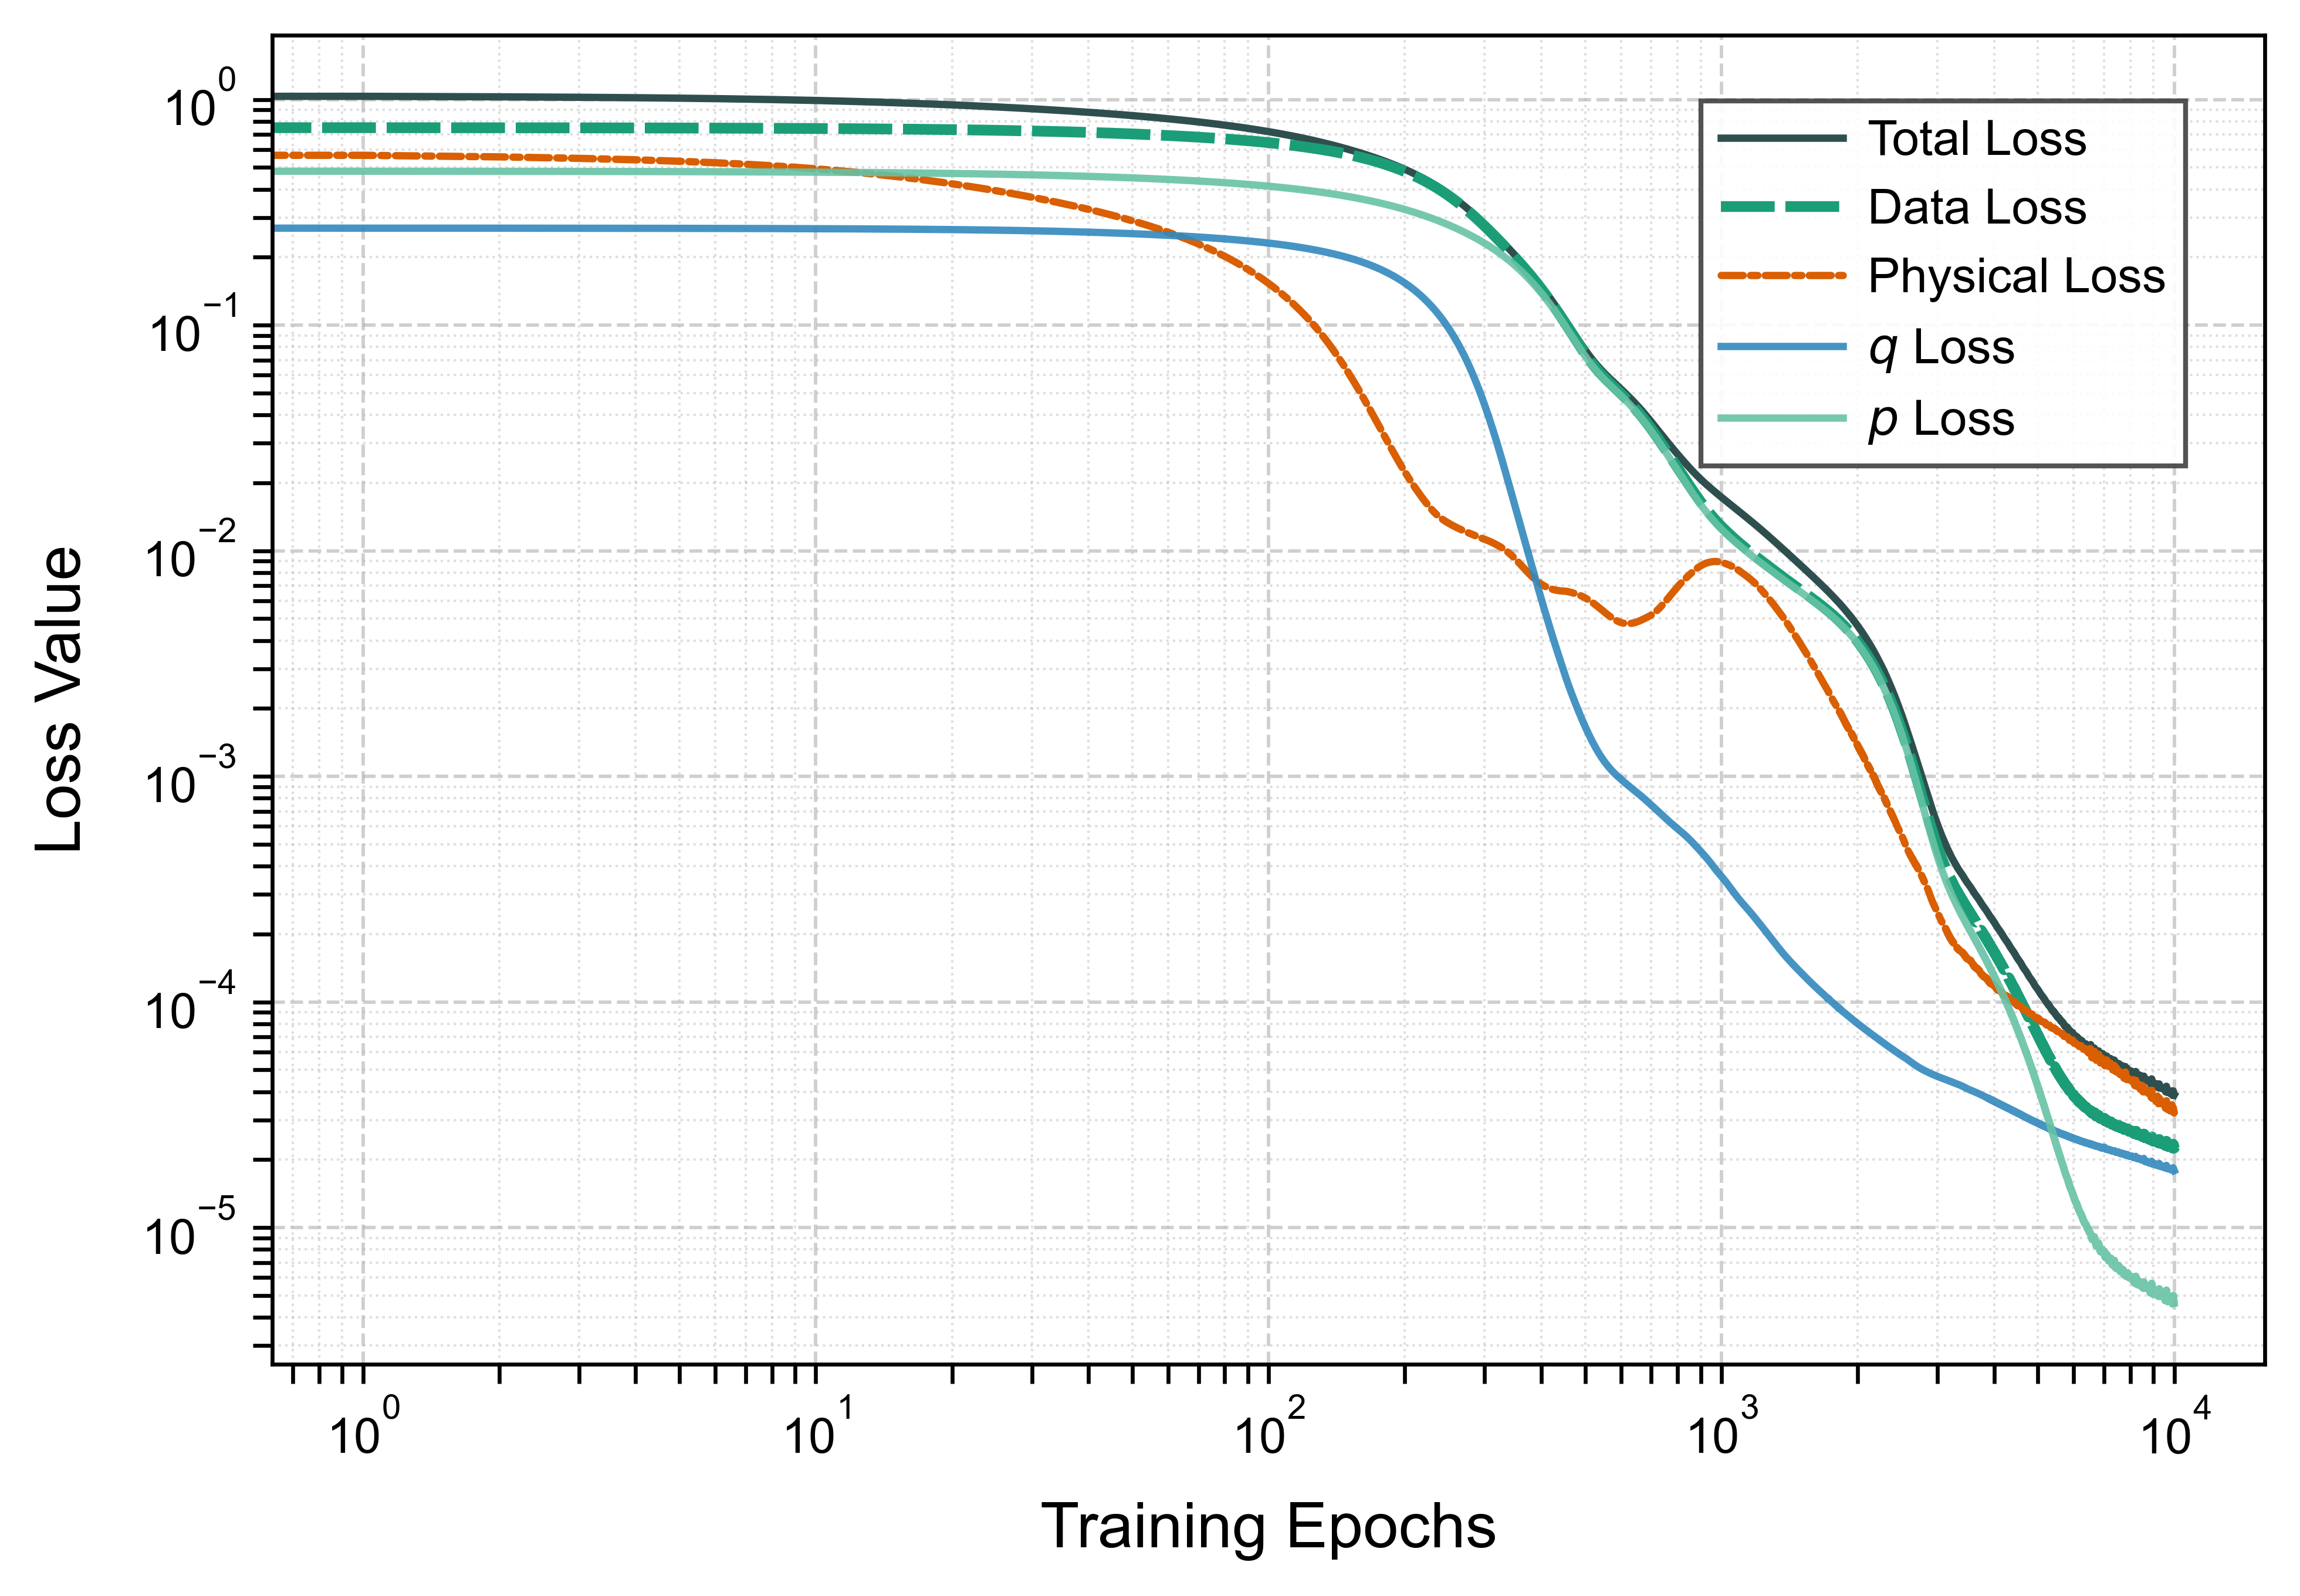

In [10]:
import matplotlib as mpl
mpl.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.6,
    'font.family': 'Arial'
})

fig, ax = plt.subplots(figsize=(7, 5), dpi=600)

COLORS = {
    'total': '#2F4F4F',
    'data': '#1b9e77',
    'physics': '#d95f02',
    'q': '#3288bd',
    'p': '#66c2a5',
    'test_p': '#fc8d62'
}

all_lines = [
    ax.loglog(total_loss_hist, color=COLORS['total'], linestyle='-', label='Total Loss')[0],
    ax.loglog(data_loss_hist, color=COLORS['data'], linestyle=(0, (5, 1)), 
             linewidth=2.2, label='Data Loss')[0],
    ax.loglog(phy_loss_hist, color=COLORS['physics'], linestyle=(0, (3, 1, 1, 1)), 
             dash_capstyle='round', label='Physical Loss')[0],
    ax.loglog(loss_components_hist[0], color=COLORS['q'], linestyle='-',
             alpha=0.9, label='$q$ Loss')[0],
    ax.loglog(loss_components_hist[1], color=COLORS['p'], linestyle='-',
             alpha=0.9, label='$p$ Loss')[0]
]

ax.set_xlabel('Training Epochs', labelpad=8)
ax.set_ylabel('Loss Value',labelpad=10)
ax.tick_params(axis='both', which='both', width=0.8, length=4)

ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.6)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

legend = ax.legend(
    handles=all_lines,
    loc='upper right',
    bbox_to_anchor=(0.98, 0.98),
    frameon=True,
    fancybox=False,
    framealpha=0.9,
    edgecolor='#404040',
    handlelength=2.5,
    handletextpad=0.5,
    borderaxespad=0.8
)

plt.tight_layout(pad=2.0)
# plt.savefig('figures/2D-undrain-loss.pdf', bbox_inches='tight', dpi=1000)
plt.show()

### Test

In [11]:
for test_num in range(1, 7):
    current_input = globals()[f'input_test{test_num}']
    ntest = current_input.shape[0]
    for i in range(ntest):
        if i == 0:
            pred_test = TANNnet.forward(current_input[i, :, 0])
            pred_test = pred_test[None, :, :]
        else:
            pred_test_i = TANNnet.forward(current_input[i, :, 0])
            pred_test = torch.cat((pred_test, pred_test_i[None, :, :]), 0)
    globals()[f'pred_test{test_num}'] = pred_test.cpu().detach()

### figure

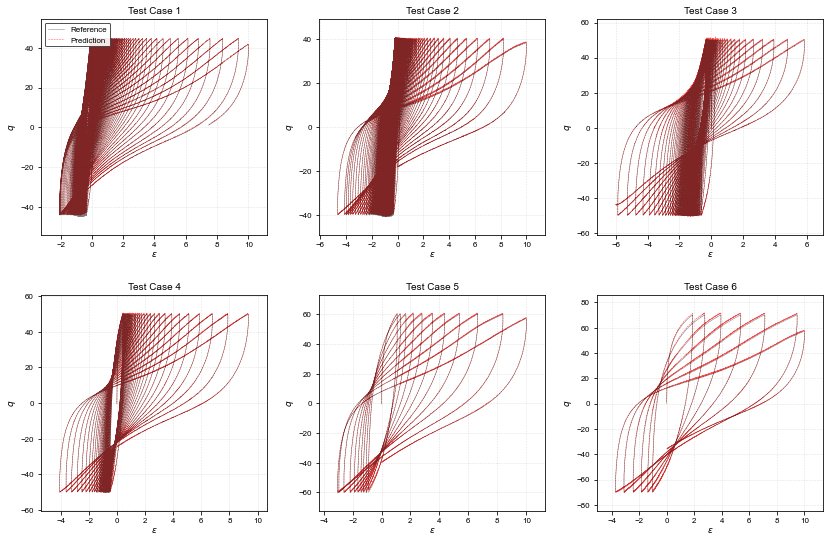

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()

for test_num in range(1, 7):
    try:
        ax = axs[test_num-1]
        
        prm_a = [p.cpu().numpy() if torch.is_tensor(p) else p 
                for p in globals()[f"prm_a_test{test_num}"]]
        prm_q = [p.cpu().numpy() if torch.is_tensor(p) else p 
                for p in globals()[f"prm_q_test{test_num}"]]
        
        i = 0
        strain = globals()[f"strain_tdt_test{test_num}"][i,:,:,0]
        q_real = globals()[f"q_tdt_test{test_num}"][i,:,0,0]
        q_pre = TANNnet.DeNormalize(
            globals()[f"pred_test{test_num}"][i,:,2],
            prm_q)
        
        ax.margins(x=0.1, y=0.1)
        ax.plot(strain, q_real, color='black', alpha=0.5, linewidth=0.5, 
               label='Reference', zorder=3)
        ax.plot(strain, q_pre, color='red', alpha=0.7, linewidth=0.5, 
               linestyle='--', label='Prediction', zorder=2)
        
        ax.set_title(f'Test Case {test_num}', fontsize=10, pad=5)
        ax.set_xlabel('$\\varepsilon$', fontsize=9, labelpad=2)
        ax.set_ylabel('$q$', fontsize=9, labelpad=2)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(True, linestyle=':', alpha=0.6)
        
        if test_num == 1:
            ax.legend(fontsize=8, loc='upper left', 
                     framealpha=0.9, edgecolor='#404040')
            
    except Exception as e:
        print(f"test {test_num} error: {str(e)}")
        continue

plt.tight_layout(pad=2.0, w_pad=1.5, h_pad=2.0)
plt.show()

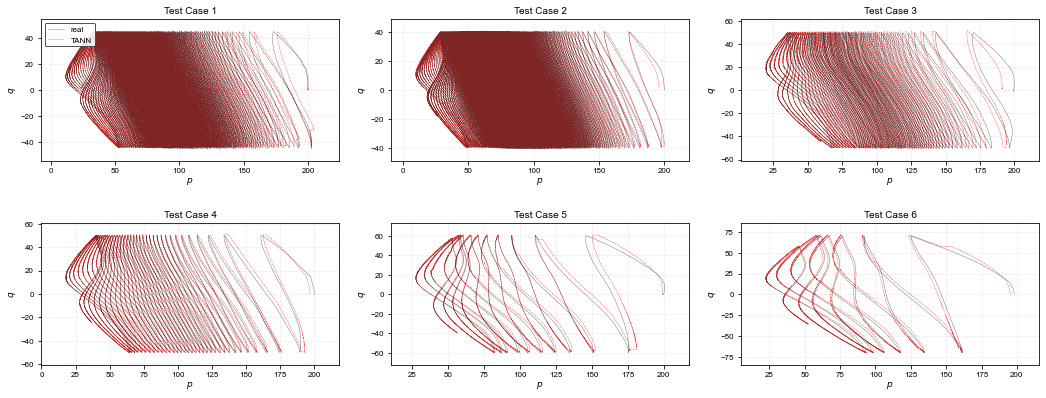

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6))
axs = axs.ravel()

for test_num in range(1, 7):
    try:
        ax = axs[test_num-1]
        
        prm_p = [p.cpu().numpy() if torch.is_tensor(p) else p 
                for p in globals()[f"prm_p_test{test_num}"]]
        prm_q = [p.cpu().numpy() if torch.is_tensor(p) else p 
                for p in globals()[f"prm_q_test{test_num}"]]
        
        i = 0
        p_real = globals()[f"p_tdt_test{test_num}"][i,:,:,0]
        q_real = globals()[f"q_tdt_test{test_num}"][i,:,0,0]
        q_pre = TANNnet.DeNormalize(
            globals()[f"pred_test{test_num}"][i,:,2],
            prm_q)
        p_pre = TANNnet.DeNormalize(
            globals()[f"pred_test{test_num}"][i,:,3],
            prm_p)        
        
        ax.margins(x=0.1, y=0.1)
        ax.plot(p_real, q_real, color='black', alpha=0.5, linewidth=0.5, 
               label='real', zorder=3)
        ax.plot(p_pre, q_pre, color='red', alpha=0.7, linewidth=0.5, 
               linestyle='--', label='TANN', zorder=2)
        
        ax.set_title(f'Test Case {test_num}', fontsize=10, pad=5)
        ax.set_xlabel('$p$', fontsize=9, labelpad=2)
        ax.set_ylabel('$q$', fontsize=9, labelpad=2)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(True, linestyle=':', alpha=0.6)
        
        if test_num == 1:
            ax.legend(fontsize=8, loc='upper left', 
                     framealpha=0.9, edgecolor='#404040')
            
    except Exception as e:
        print(f"test {test_num} error: {str(e)}")
        continue

plt.tight_layout(pad=2.0, w_pad=1.5, h_pad=2.0)
plt.show()